### Libraries

In [2]:
import SR_lib as sr 
from gen_time_ser_data import *
from analysis_data import *

In [3]:
import os
import pandas as pd
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline

import re
import pandas as pd

### Functions

In [4]:
def find_alpha_beta(Vc, Pr, tf):
    Ec= Vc/tf
    alpha = -3*np.sqrt(3)*Ec/4/Pr
    beta = 3*np.sqrt(3)*Ec/8/(Pr**3)
    print(f"VC = {Vc} V")
    print(f"Ec = {Ec*1e-5:.2e} kV/cm")
    print(f"Pr = {Pr*10} uC/cm^2")
    print(f"Landau coeff, alpha = {alpha:.2e} mF^-1, beta = {beta:.2e} m^5F^-1C^-1")
    return alpha, beta

def sd2Dext_delF(sd, rho, bw, tf, delF):
    Dext_delF = (sd**2)/(2*rho*bw*tf**2*delF)
    return Dext_delF

def Dext_delF2sd(Dext_delF, rho, bw, tf, delF):
    sd = np.sqrt(Dext_delF*2*rho*bw*tf**2*delF)
    return sd

In [5]:
def find_Ec_Pr(P,E):
    #find the zero crossing points for P
    idx1 = np.where(np.abs(P[0:int(len(P)/2)]) == np.min(np.abs(P[0:int(len(P)/2)])))
    idx2 = np.where(np.abs(P[int(len(P)/2):int(len(P))]) == np.min(np.abs(P[int(len(P)/2):int(len(P))])))
    Ec1 = E[idx1[0][0]]
    Ec2 = E[int(len(E)/2)-1 + idx2[0][0]]
    #find the zero crossing points for E
    idx2 = np.where(np.abs(E[int(len(E)/2)-10:int(len(E)/2)+10]) == np.min(np.abs(E[int(len(E)/2)-10:int(len(E)/2)+10])))
    Pr1 = P[0]
    Pr2 = P[int(len(E)/2)-10 + idx2[0][0]]
    return Ec1, Ec2, Pr1, Pr2

def TDGL(t, Pint, E, alpha, beta, rho):
    P_fit = [Pint]
    dt = t[1] - t[0]
    for i in range(1,len(t)):
        df_dp = 2*alpha*P_fit[i-1] + 4*beta*P_fit[i-1]**3 - E[i]
        P_fit.append(P_fit[i-1] - dt/rho*df_dp)
    return P_fit

#generating sine wave
def sin_wave(M, frequency, dt):
    T = 1 / frequency  # Period of the wave
    t = np.arange(0, 2*T, dt)  # Time values
    # Generate triangular wave: 0 → +max → -max → 0
    y =  M*np.sin(2*np.pi*t*frequency)
    return t, y

In [6]:
#function to load data
def load_data(file_path, start_i, end_i):
    PV_data = pd.read_excel(file_path)
    P = np.array(PV_data.iloc[start_i:end_i, 3].to_list())*1e-2 # 1e-6/1e-2/1e-2 (C/m2 conversion)
    V = np.array(PV_data.iloc[start_i:end_i, 2].to_list())
    t = np.array(PV_data.iloc[start_i:end_i, 1].to_list())*1e-3
    return P,V,t

def SR_matrics(params, f, A, raw_data_file, delw=5, delw_noise = 70):
    Vc = params.get('Vc')
    Pr = params.get('Pr')
    alpha = params.get('alpha')
    beta = params.get('beta')
    rho = params.get('rho')
    tf = params.get('tf')
    Af = params.get('Af')
    T = params.get('T')
    Asig = params.get('A')
    fsig = params.get('f')
    sd = params.get('sd')
    ts = params.get('ts')
    n = params.get('n')
    ens = params.get('ens')
    dsf = params.get('dsf')  # Downsampling factor
    bw = params.get('bw') 

    PSD = []
    PSR = []
    NF = []
    SNR = []
    COV = []
    sd_crt = []
    bw_crt = []

    t, Edrive, P = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{A}V_sd{sd[0]:.2f}_ens{0}.txt')
    E0 = Edrive
    t, Edrive, P = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{Vc*1.5}V_sd{sd[0]:.2f}_ens{0}.txt')
    Pswitch = P
    for i in range(len(sd)):
        Cov_ens = 0
        psd_ens = 0
        psd_noise_ens = 0
        for e in range(ens):
            t, Edrive, P = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{A}V_sd{sd[i]:.2f}_ens{e}.txt')
            Cov_ens += np.cov(P,Pswitch)[1,0]    
            freq, psd = sr.signal_psd(P, f, 1/(dsf*ts), delw)
            freq, psd_noise = sr.signal_psd((Edrive - E0)*tf, f, 1/(dsf*ts), delw)
            psd_ens += psd
            psd_noise_ens += psd_noise

        P_ens, NF_ens, SNR_ens = sr.power_snr_noisefloor_iisc(freq, psd_ens/ens , f,  1/(dsf*ts), delw, delw_noise)
        # P_ens, NF_ens, SNR_ens, _, _ = sr.power_snr_noisefloor(freq, psd_ens/ens , f,  1/(dsf*ts), delw, delw_noise)

        ffro = int(2*len(freq)/ (1/(dsf*ts))*(f - delw_noise)) + 1
        fto = int(2*len(freq)/ (1/(dsf*ts))*(f + delw_noise)) + 1
        
        PSD.append(psd_ens/ens)
        PSR.append(P_ens)
        NF.append(NF_ens)
        SNR.append(SNR_ens)
        COV.append(Cov_ens/ens)
        sd_crt.append(sr.sd_correction(Edrive*tf,E0*tf))
        bw_crt.append(sr.bandwith_correction(freq, psd_noise_ens/ens)[1])

    sd_crt = np.array(sd_crt)
    bw_crt = np.array(bw_crt)
    Dext_delF = np.array(sr.Dext_delF(sd, bw, alpha, beta, rho, tf, Af))
    Dext_delF_crt = np.array(sr.Dext_delF(sd_crt, bw_crt, alpha, beta, rho, tf, Af))
    return sd_crt, bw_crt, Dext_delF, Dext_delF_crt, PSR, NF, SNR, COV

def SR_matrics_exp(sd, V, P, V0, Pswitch, bw, f, alpha, beta, rho, tf, Af, delw=5, delw_noise = 70):
    # calculating the matrics
    PSD = []
    PSR = []
    NF = []
    SNR = []
    COV = []
    sd_crt = []
    bw_crt = []

    for i in range(len(sd)):
        Cov = np.cov(P[i],Pswitch)[1,0]    
        freq, psd = sr.signal_psd(P[i], f, bw, delw)
        freq, psd_noise = sr.signal_psd((V[i] - V0), f, bw, delw)
        Pwr, Nf, Snr = sr.power_snr_noisefloor_iisc(freq, psd , f,  bw, delw, delw_noise)
    
        PSD.append(psd)
        PSR.append(Pwr)
        NF.append(Nf)
        SNR.append(Snr)
        COV.append(Cov)
        sd_crt.append(sr.sd_correction(V[i],V0))
        bw_crt.append(sr.bandwith_correction(freq, psd_noise)[1])

    sd_crt = np.array(sd_crt)
    bw_crt = np.array(bw_crt)
    Dext_delF = np.array(sr.Dext_delF(sd, bw, alpha, beta, rho, tf, Af))
    Dext_delF_crt = np.array(sr.Dext_delF(sd_crt, bw, alpha, beta, rho, tf, Af))
    return sd_crt, bw_crt, Dext_delF, Dext_delF_crt, PSR, NF, SNR, COV
    

### Parameters

In [7]:
# Sample IISC
Vc = 2.1
Pr = 0.17
tf = 255e-9
rho = 1367
bw = 1e4
tf = 255e-9
Af = 1000e-12
alpha , beta = find_alpha_beta(Vc, Pr, tf)
delF = sr.del_U(0, alpha, beta, tf)[0]
print(f"barrier height = {delF:.2e}")
sd_val = 5
print(f" sd to Dext_delF convertion: sd = {sd_val} -> Dext_DelF = {sd2Dext_delF(sd_val, rho, bw, tf, delF)}")
Dext_DelF = 10
print(f" Dext_delF to sd convertion: Dext_DelF = {Dext_DelF} -> sd = {Dext_delF2sd(Dext_DelF, rho, bw, tf, delF)}")

VC = 2.1 V
Ec = 8.24e+01 kV/cm
Pr = 1.7000000000000002 uC/cm^2
Landau coeff, alpha = -6.29e+07 mF^-1, beta = 1.09e+09 m^5F^-1C^-1
barrier height = 9.09e+05
 sd to Dext_delF convertion: sd = 5 -> Dext_DelF = 15.464689576323975
 Dext_delF to sd convertion: Dext_DelF = 10 -> sd = 4.02067899377736


In [8]:
## Read the Parse file
params_path = 'sim_8\\parameters.txt'  # Parse input file
params = sr.read_simulation_parameters(params_path)
## Create the simulation directory
id = params.get('id')
output_dir = f'sim_{id}'
os.makedirs(output_dir, exist_ok=True)
raw_data_file = os.path.join(output_dir, "raw_data")

In [9]:
Asig = params.get('A')
fsig = [75, 100, 150]
clr = ["blue", "black", "red"]
styl = ["-s", "-o", "-^"]
# Dext_DelF_opt = sd2Dext_delF(np.array(sd_opt_f), rho, bw, tf, delF)
sd_crt_f = []
bw_crt_f = []
Dext_delF_f = []
Dext_delF_crt_f = []
PSR_f = []
NF_f = []
SNR_f = []
COV_f = [] 
for i in range(len(fsig)):
    f = fsig[i]
    A = Asig[0]
    sd_crt, bw_crt, Dext_delF, Dext_delF_crt, PSR, NF, SNR, COV = SR_matrics(params, f, A, raw_data_file, delw=5, delw_noise = 70)
    
    idx_sort = np.argsort(Dext_delF_crt)
    Dext_delF_crt = Dext_delF_crt[idx_sort]
    PSR = np.array(PSR)[idx_sort]
    NF = np.array(NF)[idx_sort]
    SNR = np.array(SNR)[idx_sort]
    COV = np.array(COV)[idx_sort]

    sd_crt_f.append(sd_crt)
    bw_crt_f.append(bw_crt)
    Dext_delF_f.append(Dext_delF)
    Dext_delF_crt_f.append(Dext_delF_crt)
    PSR_f.append(PSR)
    NF_f.append(NF)
    SNR_f.append(SNR)
    COV_f.append(COV)

    print(f"freqency {f} Hz done!")

freqency 75 Hz done!
freqency 100 Hz done!
freqency 150 Hz done!


### Measurement

In [10]:
IISc_data_path = "C:\\Drive\\FE_SR\\IITPKD_data_analysis\\sim_for_final_figs\\IISc_data\\"

#load all the data's 75 Hz, 100Hz, 150 Hz
sd = np.linspace(0.0,5.1,35)
P_data = []
V_data = []
t_data = []

start_i, end_i = [45, 45, 45], [20067, 17592, 15042] #index of the data
f_data = [75, 100, 150]

#index after the poling pulse
fro = int(bw + 48)

for j in range(0,3):
    P_f = []
    V_f = []
    t_f = []
    for i in range(0,len(sd)):
        file_path = IISc_data_path + f'new_{f_data[j]}Hz\\{sd[i]:.2f}.xls'    
        Ptemp, Vtemp, ttemp = load_data(file_path, start_i[j], end_i[j])    
        P_f.append(np.array(Ptemp[fro:]))
        V_f.append(np.array(Vtemp[fro:]))
        t_f.append(np.array(ttemp[fro:]))
    P_data.append(P_f)
    V_data.append(V_f)
    t_data.append(t_f)

# reading Hyst data (for the super threshold signal)
PV_data = pd.read_excel(IISc_data_path + "hyst_1000hz.xlsx")
Pswitch = np.array(PV_data.iloc[46:43+2002, 3].to_list())*1e-2 # 1e-6/1e-2/1e-2 (C/m2 conversion)
tswitch = np.array(PV_data.iloc[46:43+2002, 1].to_list())*1e-3

In [ ]:
sd_crt_exp_f = []
bw_crt_exp_f = []
Dext_delF_exp_f = []
Dext_delF_crt_exp_f = []
PSR_exp_f = []
NF_exp_f = []
SNR_exp_f = []
COV_exp_f = []

for i in range(len(f_data)):
    V = V_data[i]
    V0 = V_data[i][0]
    P = P_data[i]
    
    # code to make the Pswitch signal
    P_switch = list(Pswitch*2/3)*75
    time_switch = np.linspace(t_data[i][0][0], t_data[i][0][-1], len(P_switch))
    time_switch_gen = t_data[i][0]
    interp_func = interp1d(time_switch, P_switch, kind='linear', fill_value='extrapolate')
    P_switch_gen = interp_func(time_switch_gen)

    sd_crt_exp, bw_crt_exp, Dext_delF_exp, Dext_delF_crt_exp, PSR_exp, NF_exp, SNR_exp, COV_exp = SR_matrics_exp(sd, V, P, V0, P_switch_gen, bw, f_data[i], alpha, beta, rho, tf, Af, delw=5, delw_noise = 70)    
    #sorting
    idx_sort = np.argsort(Dext_delF_crt_exp)
    Dext_delF_crt_exp = Dext_delF_crt_exp[idx_sort]
    PSR_exp = np.array(PSR_exp)[idx_sort]
    NF_exp = np.array(NF_exp)[idx_sort]
    SNR_exp = np.array(SNR_exp)[idx_sort]
    COV_exp = np.array(COV_exp)[idx_sort]

    sd_crt_exp_f.append(sd_crt_exp)
    bw_crt_exp_f.append(bw_crt_exp)
    Dext_delF_exp_f.append(Dext_delF_exp)
    Dext_delF_crt_exp_f.append(Dext_delF_crt_exp)
    PSR_exp_f.append(PSR_exp)
    NF_exp_f.append(NF_exp)
    SNR_exp_f.append(SNR_exp)
    COV_exp_f.append(COV_exp)

In [ ]:
# debuging the two finshy data points in 75hz SNR metric
# print(10*np.log10(SNR_exp_f[0]))
# print(10*np.log10(SNR_exp_f[0][8]), 10*np.log10(SNR_exp_f[0][10]))

# freq, psd = sr.signal_psd(P_data[0][11], f, bw, delw=70)
# plt.loglog(freq, psd)

# freq, psd = sr.signal_psd(P_data[0][10], f, bw, delw=70)
# plt.loglog(freq, psd)

# P = P_data[i]
# code to make the Pswitch signal
# P_switch = list(Pswitch*2/3)*75
# time_switch = np.linspace(t_data[0][0][0], t_data[0][0][-1], len(P_switch))
# time_switch_gen = t_data[0][0]
# interp_func = interp1d(time_switch, P_switch, kind='linear', fill_value='extrapolate')
# P_switch_gen = interp_func(time_switch_gen)


# _,_,_,_, PSR_exp_f_new,_, SNR_exp_f_new, COV_exp_f_new = SR_matrics_exp(sd, V_data[0], P_data[0], V_data[0][0], P_switch_gen, bw, f_data[0], alpha, beta, rho, tf, Af, delw=5, delw_noise = 60)    
# PSR_exp_f[0][8], SNR_exp_f[0][8], _ = PSR_exp_f_new[8] , SNR_exp_f_new[8], COV_exp_f_new[8]
# # _,_,_,_, PSR_exp_f_new,_, SNR_exp_f_new, COV_exp_f_new = SR_matrics_exp(sd, V_data[0], P_data[0], V_data[0][0], P_switch_gen, bw, f_data[0], alpha, beta, rho, tf, Af, delw=5, delw_noise = 40)    
# PSR_exp_f[0][10], SNR_exp_f[0][10], _ = PSR_exp_f_new[10] , SNR_exp_f_new[10], COV_exp_f_new[10]

In [17]:
# making spline fit for simulation
# Create a dense x-axis for smooth plots
Dext_delF_smooth_f = []
psr_smooth_f = []
snr_smooth_f = []
cov_smooth_f = []

Dext_delF_exp_smooth_f = []
psr_exp_smooth_f = []
snr_exp_smooth_f = []
cov_exp_smooth_f = []

for i in range(len(f_data)):
    print(f_data[i])
    Dext_delF_smooth = np.linspace(np.min(Dext_delF_crt_f[i]), np.max(Dext_delF_crt_f[i]), 300)

    # Spline interpolation for each curve
    psr_spline = UnivariateSpline(Dext_delF_crt_f[i], 10*np.log10(PSR_f[i]), s= 0.5)
    snr_spline = UnivariateSpline(Dext_delF_crt_f[i], 10*np.log10(SNR_f[i]), s=2)
    cov_spline = UnivariateSpline(Dext_delF_crt_f[i], COV_f[i], s=0)

    # Evaluate spline on the smooth x-axis
    psr_smooth = psr_spline(Dext_delF_smooth)
    snr_smooth = snr_spline(Dext_delF_smooth)
    cov_smooth = cov_spline(Dext_delF_smooth)

    Dext_delF_smooth_f.append(Dext_delF_smooth)
    psr_smooth_f.append(psr_smooth)
    snr_smooth_f.append(snr_smooth)
    cov_smooth_f.append(cov_smooth)

    # making spline fit for experiment
    # Create a dense x-axis for smooth plots
    Dext_delF_exp_smooth = np.linspace(np.min(Dext_delF_crt_exp_f[i]), np.max(Dext_delF_crt_exp_f[i]), 300)

    # Spline interpolation for each curve
    psr_exp_spline = UnivariateSpline(Dext_delF_crt_exp_f[i], 10*np.log10(PSR_exp_f[i]), s= 0.5)
    snr_exp_spline = UnivariateSpline(Dext_delF_crt_exp_f[i], 10*np.log10(SNR_exp_f[i]), s=5)
    cov_exp_spline = UnivariateSpline(Dext_delF_crt_exp_f[i], COV_exp_f[i], s=0)

    # Evaluate spline on the smooth x-axis
    psr_exp_smooth = psr_exp_spline(Dext_delF_exp_smooth)
    snr_exp_smooth = snr_exp_spline(Dext_delF_exp_smooth)
    cov_exp_smooth = cov_exp_spline(Dext_delF_exp_smooth)

    Dext_delF_exp_smooth_f.append(Dext_delF_exp_smooth)
    psr_exp_smooth_f.append(psr_exp_smooth)
    snr_exp_smooth_f.append(snr_exp_smooth)
    cov_exp_smooth_f.append(cov_exp_smooth)

75
100
150


### Simulation vs Measurment

<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:33: SyntaxWarning: invalid escape sequence '\D'
<>:46: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:33: SyntaxWarning: invalid escape sequence '\D'
<>:46: SyntaxWarning: invalid escape sequence '\D'
C:\Users\manik\AppData\Local\Temp\ipykernel_10744\2851148463.py:18: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
C:\Users\manik\AppData\Local\Temp\ipykernel_10744\2851148463.py:33: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
C:\Users\manik\AppData\Local\Temp\ipykernel_10744\2851148463.py:46: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignore

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

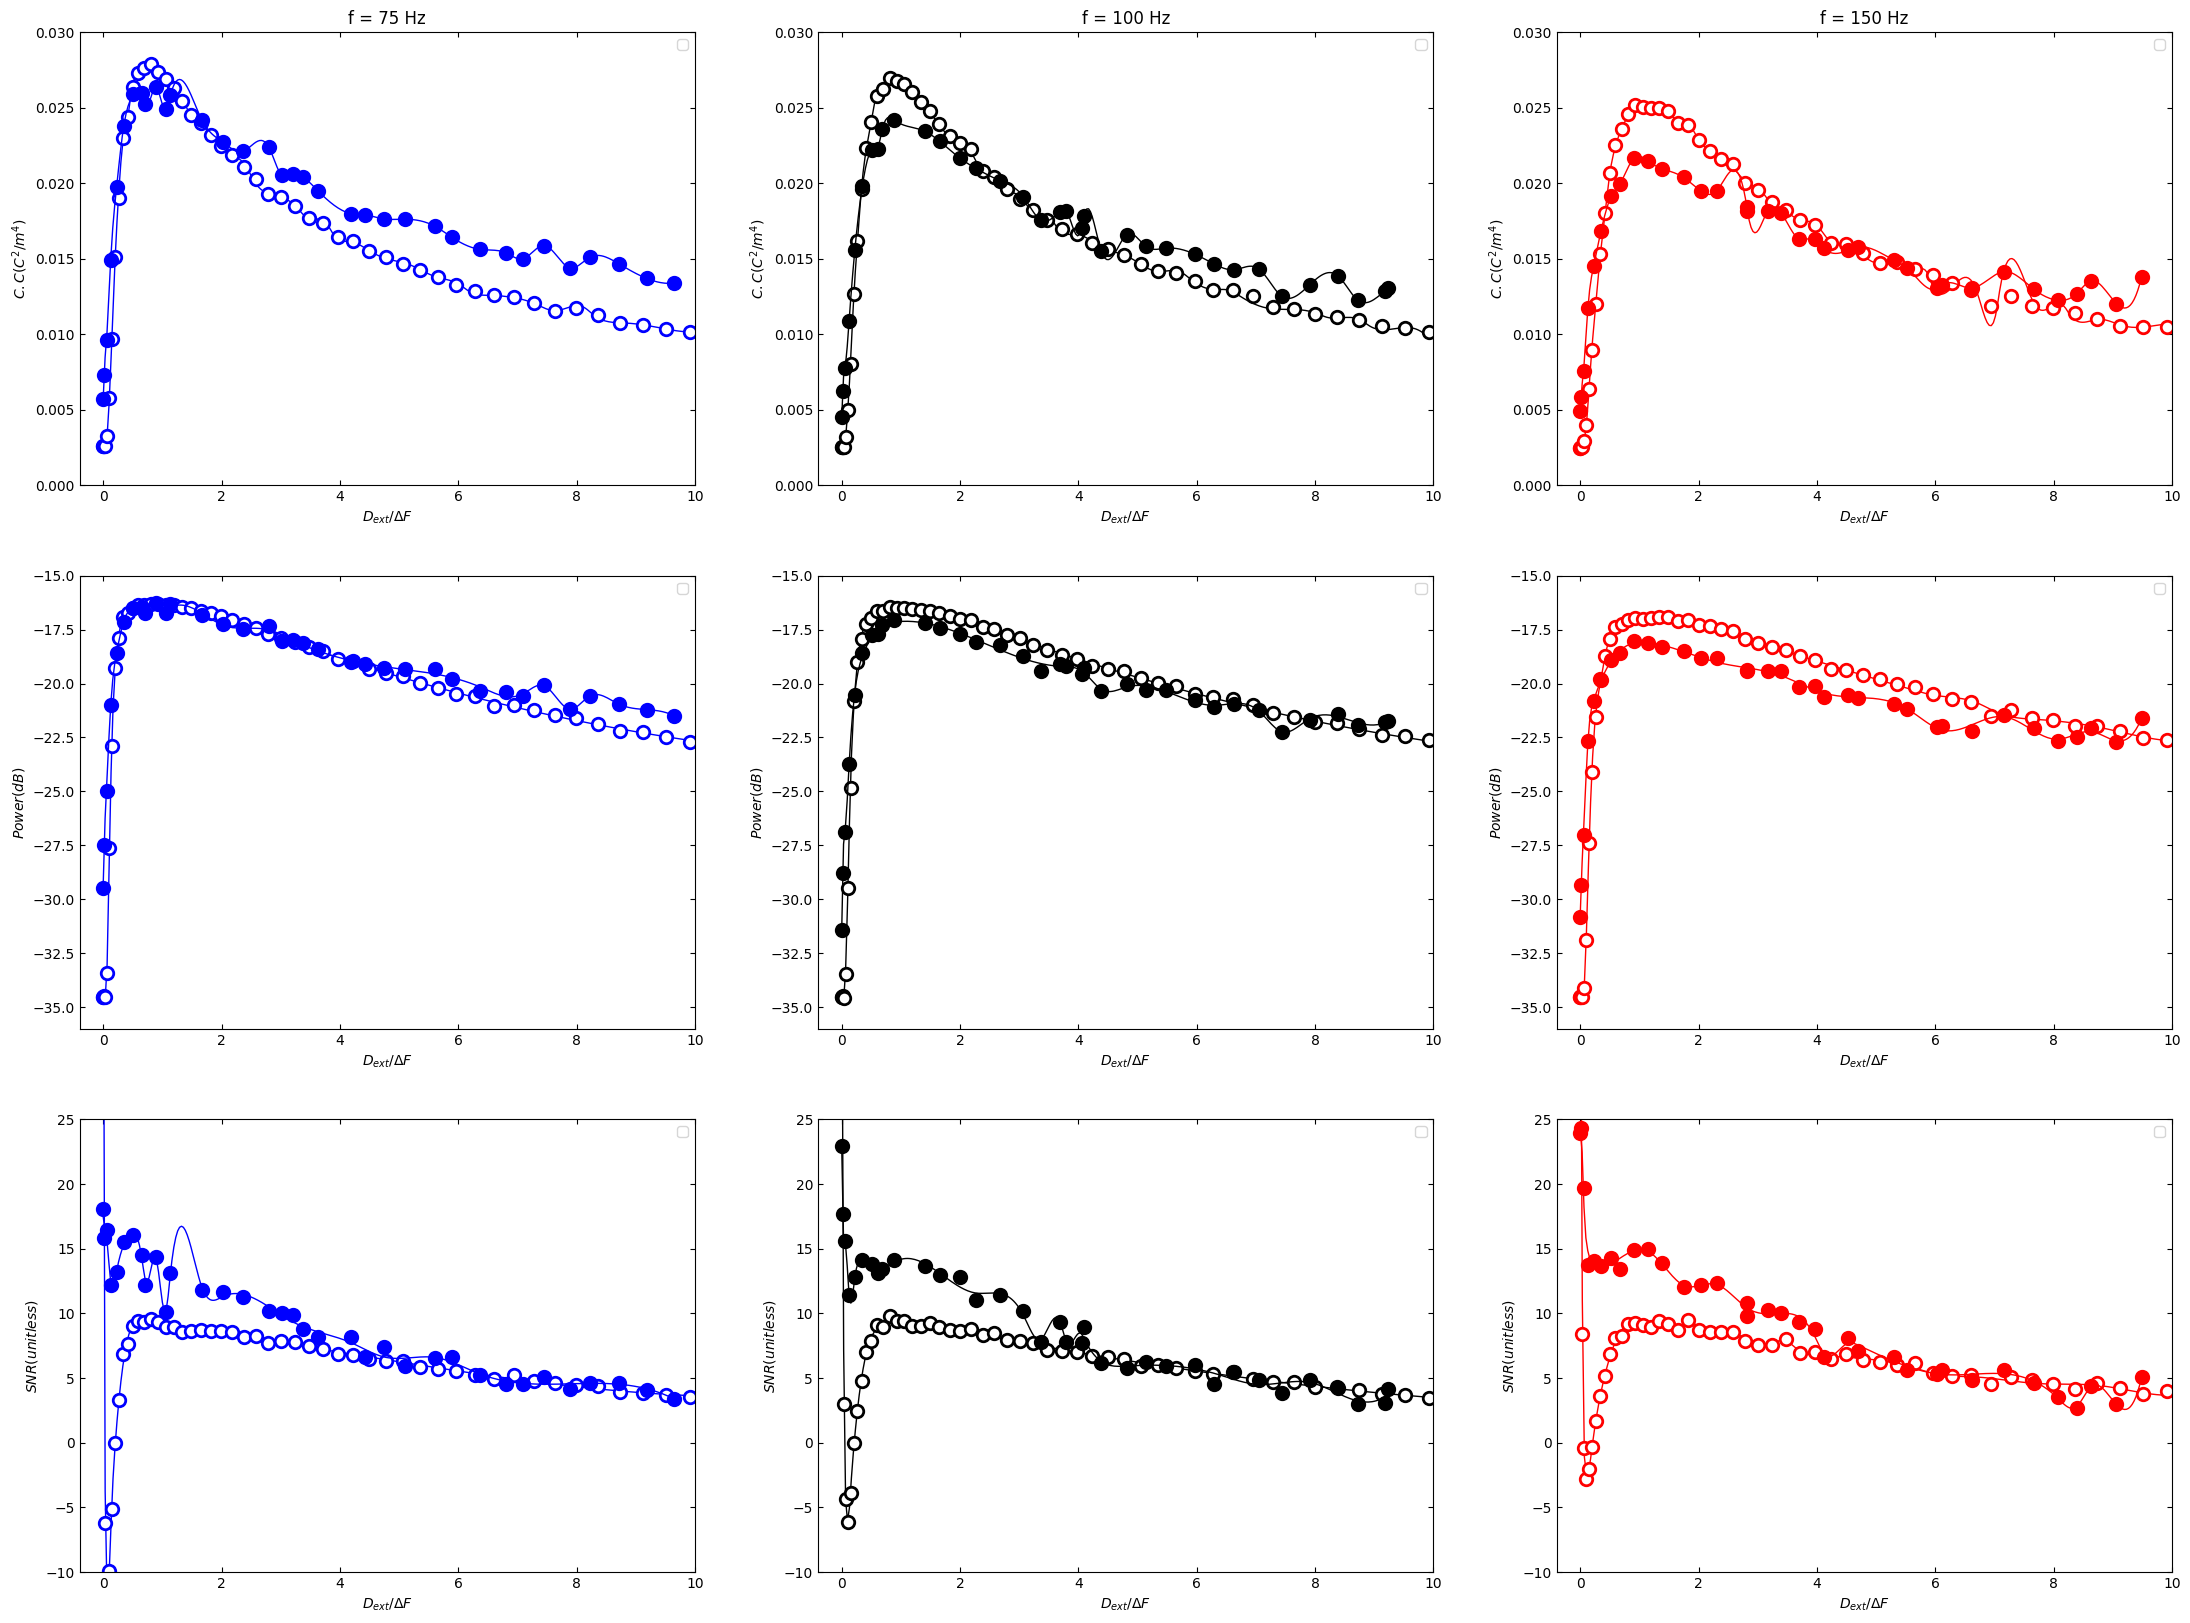

In [18]:
# Measurement only
lwth = 1
mwth = 2
ms = 9
clr = ["blue", "black", "red"]
styl = ["o", "o", "o"]

plt.figure(figsize=(27, 20))
for i in range(len(f_data)):
    plt.subplot(3,3,i+1)

    plt.plot(Dext_delF_smooth_f[i], cov_smooth_f[i], "-", linewidth = lwth, c = clr[i])
    plt.plot(Dext_delF_f[i], COV_f[i], styl[i], linewidth = lwth, mew = mwth, markersize=ms, markerfacecolor='white', c = clr[i])

    plt.plot(Dext_delF_exp_smooth_f[i], cov_exp_smooth_f[i], "-", linewidth = lwth, c = clr[i])
    plt.plot(Dext_delF_crt_exp_f[i], COV_exp_f[i], styl[i], linewidth = lwth, mew = mwth, markersize=ms, c = clr[i])

    plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
    # plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
    plt.tick_params(axis='both', direction='in', top=True, right=True)
    plt.xlim([-0.4, 10])
    plt.ylim([0, 0.03])
    plt.title(f"f = {f_data[i]} Hz")

    plt.subplot(3,3,4+i)
    plt.plot(Dext_delF_smooth_f[i], psr_smooth_f[i], "-", linewidth = lwth, c = clr[i])
    plt.plot(Dext_delF_f[i], 10*np.log10(PSR_f[i]), styl[i], linewidth = lwth, mew = mwth, markersize=ms, markerfacecolor='white', c = clr[i])
    
    plt.plot(Dext_delF_exp_smooth_f[i], psr_exp_smooth_f[i], "-", linewidth = lwth, c = clr[i])
    plt.plot(Dext_delF_crt_exp_f[i], 10*np.log10(PSR_exp_f[i]), styl[i], linewidth = lwth, mew = mwth, markersize=ms,  c = clr[i])
    plt.xlim([-0.4, 10])
    plt.ylim([-36, -15])
    plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
    # plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
    plt.tick_params(axis='both', direction='in', top=True, right=True  )
    
    plt.subplot(3,3,7+i)
    plt.plot(Dext_delF_smooth_f[i], snr_smooth_f[i], "-", linewidth = lwth, c = clr[i])
    plt.plot(Dext_delF_f[i], 10*np.log10(SNR_f[i]), styl[i], linewidth = lwth, mew = mwth, markersize=ms, markerfacecolor='white',  c = clr[i])
    
    plt.plot(Dext_delF_exp_smooth_f[i], snr_exp_smooth_f[i], "-", linewidth = lwth, c = clr[i])
    plt.plot(Dext_delF_crt_exp_f[i], 10*np.log10(SNR_exp_f[i]), styl[i], linewidth = lwth, mew = mwth, markersize=ms, c = clr[i])

    plt.xlim([-0.4, 10])
    plt.ylim([-10, 25])
    plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.legend()
    # plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
    plt.tick_params(axis='both', direction='in', top=True, right=True  )

# plt.savefig("fig//IISc_SR_metric_meas_all_freq_bw70.pdf")


### Time series plots

Top Row SD = 0.33
Top Row SD = 1.14
Top Row SD = 3.02
Bottom Row SD = 0.3
Bottom Row SD = 1.05
Bottom Row SD = 3.0


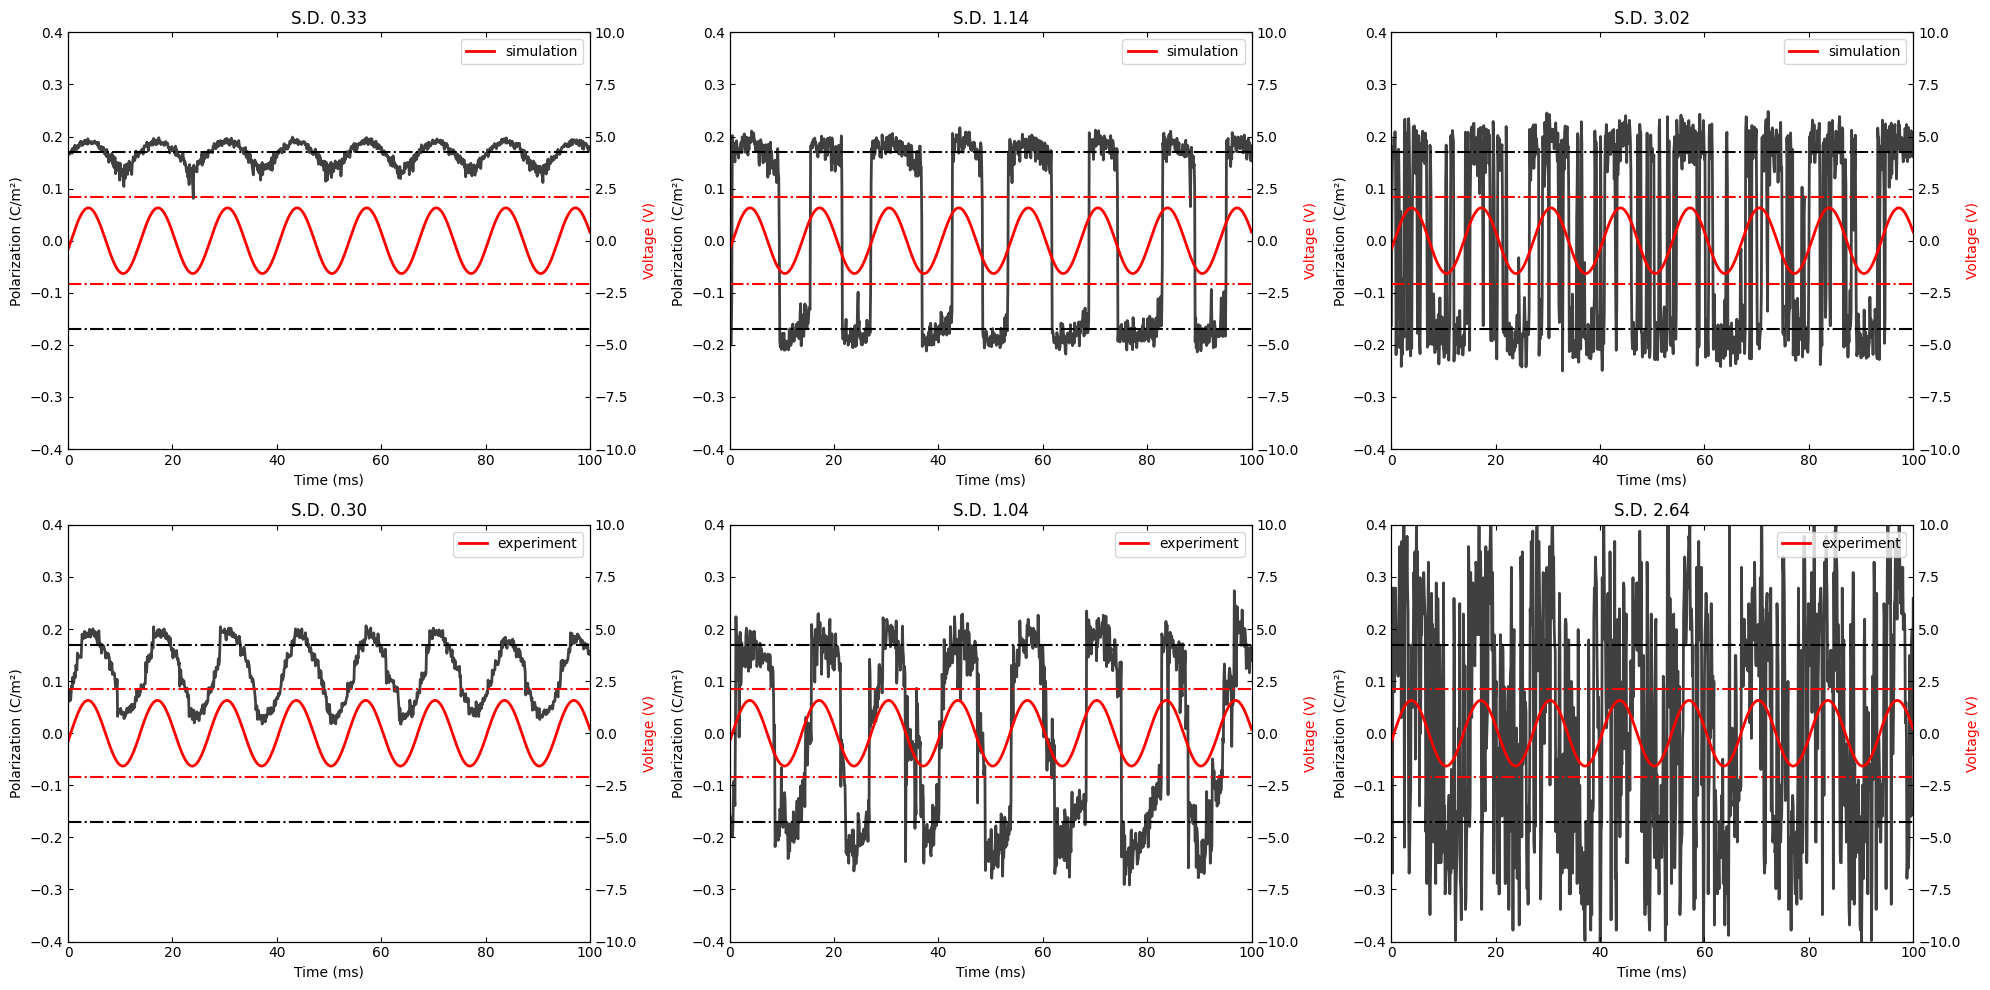

In [50]:
sd_values_top = [0.33, 1.14, 3.02]
sd_values_bottom = [0.3, 1.05, 3.0]
clr = ["red", "black"]
lnwidth = [2, 2]
dt_top = 1e-4
dt_bottom = 1e-4
alpha_P = 0.75
alpha_V = 0.3

fro1_top = 660
fro1_bottom = 660 + int(bw + 48)

f_sig = 75
no_cycle = 10*f_sig/100

to1_top = int(fro1_top + no_cycle / (f_sig * dt_top) + 1)
to1_bottom = int(fro1_bottom + no_cycle / (f_sig * dt_bottom) + 1)

V_range = 10
P_range = 0.4

Vc = 2.1
Pr = 0.17


plt.figure(figsize=(20, 10))
# First row
for e, sd in enumerate(sd_values_top):
    print(f"Top Row SD = {sd}")
    t_data, V_data, P_data = sr.read_tEP_data(raw_data_file + f'\\PE_{f_sig}hz_{A}V_sd{sd:.2f}_ens{1}.txt')
    t_data, V_data_0, _ = sr.read_tEP_data(raw_data_file + f'\\PE_{f_sig}hz_{A}V_sd{0:.2f}_ens{1}.txt')

    dt = t_data[1] - t_data[0]
    V_data = V_data[fro1_top:to1_top] * tf
    V_data_0 = V_data_0[fro1_top:to1_top] * tf
    P_data = P_data[fro1_top:to1_top]
    t_data = np.linspace(0, (len(V_data)-1)*dt, len(V_data))*1e3
    V_data = np.clip(V_data, -V_range, V_range)
    P_data = np.clip(P_data, -P_range, P_range)

    ax1 = plt.subplot(2, 3, e+1)
    
    ax1.plot(t_data, P_data, color=clr[1], linewidth =  lnwidth[1], alpha = alpha_P)
    ax1.set_ylim([-P_range, P_range])
    ax1.axhline(y=Pr, linestyle='-.', color=clr[1])
    ax1.axhline(y=-Pr, linestyle='-.', color=clr[1])
    ax1.set_ylabel('Polarization (C/m²)', color=clr[1])
    ax1.set_xlabel('Time (ms)')
    ax1.tick_params(axis='both', direction='in', top=True, right=True)
    
    ax2 = ax1.twinx()

    # ax2.plot(t_data, V_data, color=clr[0], linewidth = lnwidth[0], alpha = alpha_V)
    ax2.plot(t_data, V_data_0, color=clr[0], linewidth = lnwidth[0])

    ax2.set_ylim([-V_range, V_range])
    ax2.set_xlim(t_data[0], t_data[-1])
    ax2.axhline(y=Vc, linestyle='-.', color=clr[0])
    ax2.axhline(y=-Vc, linestyle='-.', color=clr[0])
    ax2.set_ylabel('Voltage (V)', color=clr[0])
    ax2.set_xlabel('Time (ms)')
    ax2.set_title(f"S.D. {sd:.2f}")
    ax2.tick_params(axis='both', direction='in', top=True, right=True)
    ax2.legend(["simulation"])

    

# for finding the corrected sd
start_i, end_i = [45, 45, 45], [20067, 17592, 15042] #index of the data
#index after the poling pulse
fro = int(bw + 48)
j = 2
file_path = IISc_data_path + f'new_{f_sig}Hz\\0.00.xls'   
t_data, V_data, P_data = load_data(file_path, start_i[j], end_i[j])    
V0 =  V_data[fro:]

# Second row
for e, sd in enumerate(sd_values_bottom):
    print(f"Bottom Row SD = {sd}")
    file_path = IISc_data_path + f'new_{f_sig}Hz\\{sd:.2f}.xls'
    P_data, V_data, t_data = load_data(file_path, start_i[j], end_i[j])
    file_path = IISc_data_path + f'new_{f_sig}Hz\\{0.00:.2f}.xls'
    _, V_data_0, t_data = load_data(file_path, start_i[j], end_i[j])

    sd_crt_plt =  sr.sd_correction(V_data[fro:],V0)
    dt = (t_data[1] - t_data[0])
    V_data = V_data[fro1_bottom:to1_bottom]
    V_data_0 = V_data_0[fro1_bottom:to1_bottom]
    P_data = P_data[fro1_bottom:to1_bottom]
    V_data = V_data[::1]
    V_data_0 = V_data_0[::1]
    P_data = P_data[::1]
    t_data = np.linspace(0, (len(V_data)-1)*dt, len(V_data))*1e3
    V_data = np.clip(V_data, -V_range, V_range)
    P_data = np.clip(P_data, -P_range, P_range)

    ax1 = plt.subplot(2, 3, e+4)
    
    ax1.plot(t_data, P_data, color=clr[1], linewidth = lnwidth[1], alpha = alpha_P)
    ax1.set_ylim([-P_range, P_range])
    ax1.axhline(y=Pr, linestyle='-.', color=clr[1])
    ax1.axhline(y=-Pr, linestyle='-.', color=clr[1])
    ax1.set_ylabel('Polarization (C/m²)', color=clr[1])
    ax1.set_xlabel('Time (ms)')
    ax1.tick_params(axis='both', direction='in', top=True, right=True)

    ax2 = ax1.twinx()

    # ax2.plot(t_data, V_data, color=clr[0], linewidth = lnwidth[0], alpha = alpha_V)
    ax2.plot(t_data, V_data_0, color=clr[0], linewidth = lnwidth[0])

    ax2.set_ylim([-V_range, V_range])
    ax2.set_xlim(t_data[0], t_data[-1])
    ax2.axhline(y=Vc, linestyle='-.', color=clr[0])
    ax2.axhline(y=-Vc, linestyle='-.', color=clr[0])
    ax2.set_ylabel('Voltage (V)', color=clr[0])
    ax2.set_xlabel('Time (ms)')
    ax2.set_title(f"S.D. {sd_crt_plt:.2f}")
    ax2.tick_params(axis='both', direction='in', top=True, right=True)
    ax2.legend(["experiment"])


plt.tight_layout()
plt.savefig(f"fig//IISc_P_t_data_{f_sig}hz.pdf")
plt.show()


Top Row SD = 0.33
Top Row SD = 1.14
Top Row SD = 3.02
Bottom Row SD = 0.3
Bottom Row SD = 1.05
Bottom Row SD = 3.0


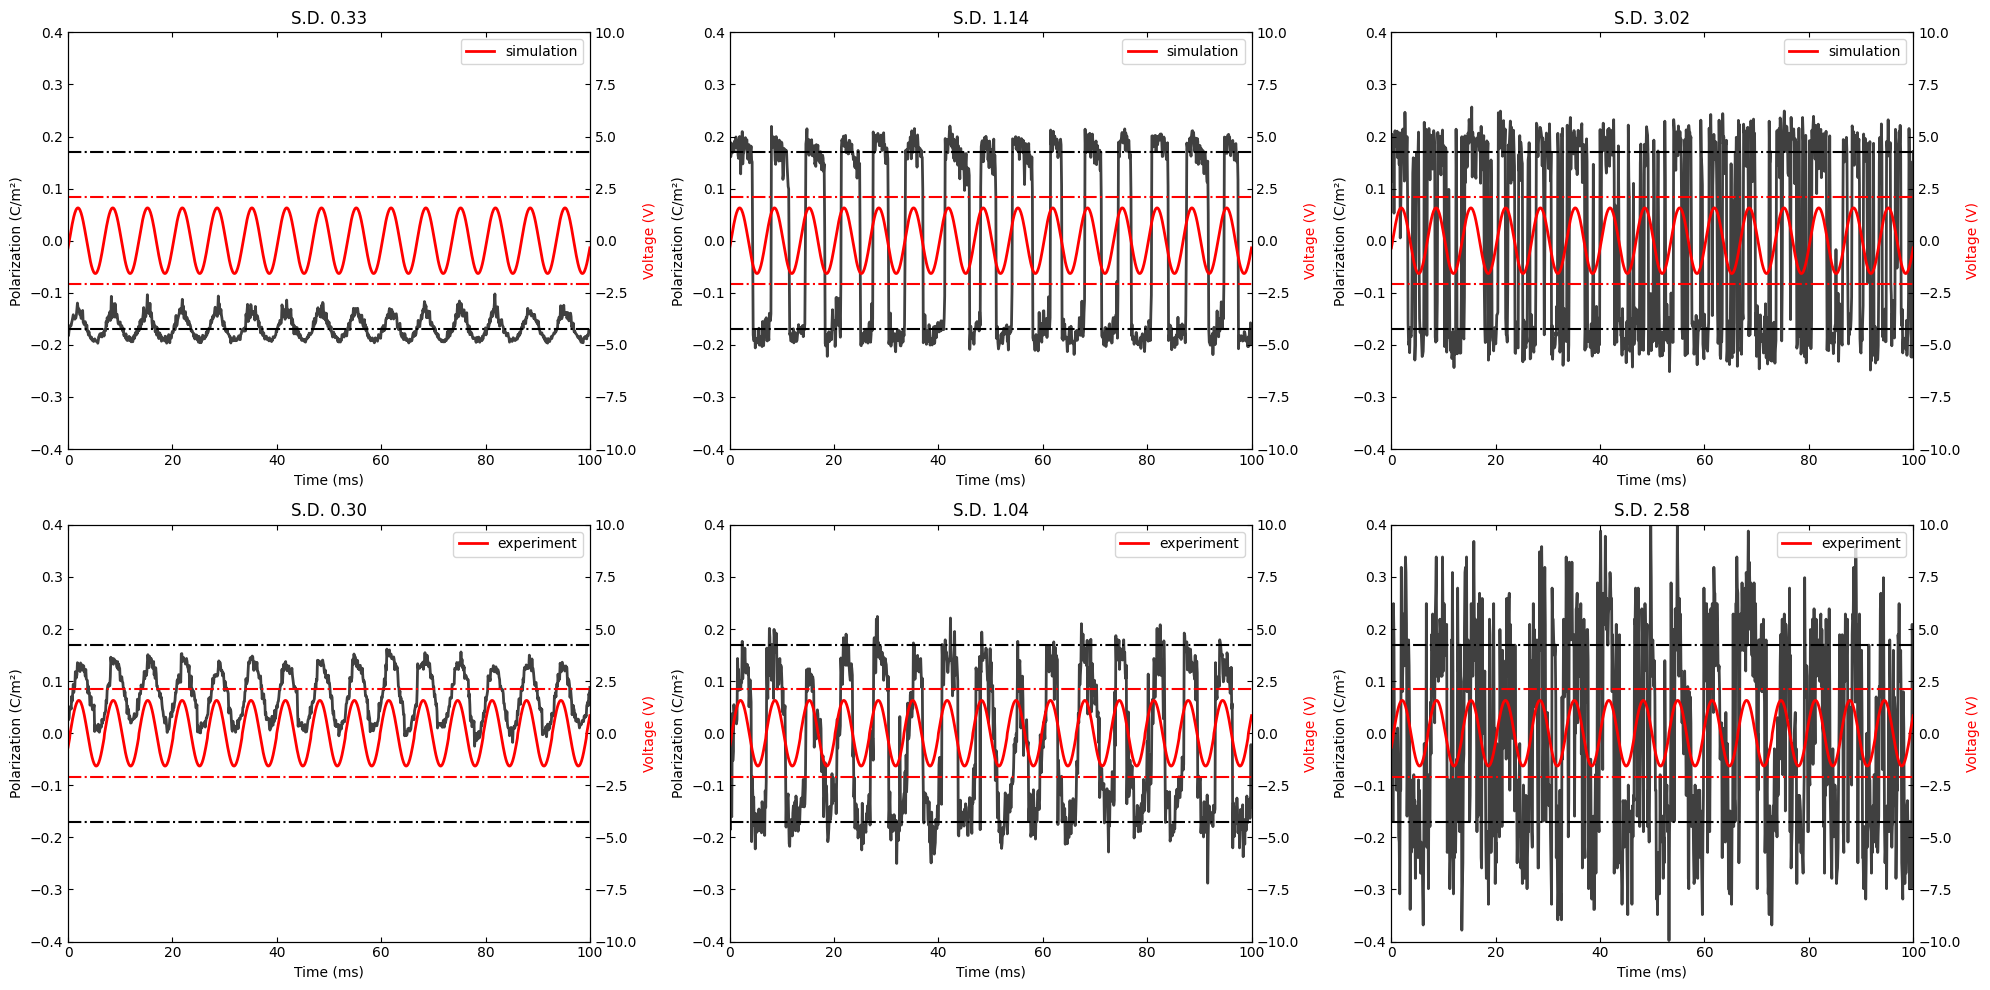

In [44]:
sd_values_top = [0.33, 1.14, 3.02]
sd_values_bottom = [0.3, 1.05, 3.0]
clr = ["red", "black"]
lnwidth = [2, 2]
dt_top = 1e-4
dt_bottom = 1e-4
alpha_P = 0.75
alpha_V = 0.3

fro1_top = 1530
fro1_bottom = 1530 + int(bw + 48 + 446)

f_sig = 150
no_cycle = 10*f_sig/100

to1_top = int(fro1_top + no_cycle / (f_sig * dt_top) + 1)
to1_bottom = int(fro1_bottom + no_cycle / (f_sig * dt_bottom) + 1)

V_range = 10
P_range = 0.4

Vc = 2.1
Pr = 0.17


plt.figure(figsize=(20, 10))
# First row
for e, sd in enumerate(sd_values_top):
    print(f"Top Row SD = {sd}")
    t_data, V_data, P_data = sr.read_tEP_data(raw_data_file + f'\\PE_{f_sig}hz_{A}V_sd{sd:.2f}_ens{1}.txt')
    t_data, V_data_0, _ = sr.read_tEP_data(raw_data_file + f'\\PE_{f_sig}hz_{A}V_sd{0:.2f}_ens{1}.txt')

    dt = t_data[1] - t_data[0]
    V_data = V_data[fro1_top:to1_top] * tf
    V_data_0 = V_data_0[fro1_top:to1_top] * tf
    P_data = P_data[fro1_top:to1_top]
    t_data = np.linspace(0, (len(V_data)-1)*dt, len(V_data))*1e3
    V_data = np.clip(V_data, -V_range, V_range)
    P_data = np.clip(P_data, -P_range, P_range)

    ax1 = plt.subplot(2, 3, e+1)
    
    ax1.plot(t_data, P_data, color=clr[1], linewidth =  lnwidth[1], alpha = alpha_P)
    ax1.set_ylim([-P_range, P_range])
    ax1.axhline(y=Pr, linestyle='-.', color=clr[1])
    ax1.axhline(y=-Pr, linestyle='-.', color=clr[1])
    ax1.set_ylabel('Polarization (C/m²)', color=clr[1])
    ax1.set_xlabel('Time (ms)')
    ax1.tick_params(axis='both', direction='in', top=True, right=True)
    
    ax2 = ax1.twinx()

    # ax2.plot(t_data, V_data, color=clr[0], linewidth = lnwidth[0], alpha = alpha_V)
    ax2.plot(t_data, V_data_0, color=clr[0], linewidth = lnwidth[0])

    ax2.set_ylim([-V_range, V_range])
    ax2.set_xlim(t_data[0], t_data[-1])
    ax2.axhline(y=Vc, linestyle='-.', color=clr[0])
    ax2.axhline(y=-Vc, linestyle='-.', color=clr[0])
    ax2.set_ylabel('Voltage (V)', color=clr[0])
    ax2.set_xlabel('Time (ms)')
    ax2.set_title(f"S.D. {sd:.2f}")
    ax2.tick_params(axis='both', direction='in', top=True, right=True)
    ax2.legend(["simulation"])

    

# for finding the corrected sd
start_i, end_i = [45, 45, 45], [20067, 17592, 15042] #index of the data
#index after the poling pulse
fro = int(bw + 48)
j = 2
file_path = IISc_data_path + f'new_{f_sig}Hz\\0.00.xls'   
t_data, V_data, P_data = load_data(file_path, start_i[j], end_i[j])    
V0 =  V_data[fro:]

# Second row
for e, sd in enumerate(sd_values_bottom):
    print(f"Bottom Row SD = {sd}")
    file_path = IISc_data_path + f'new_{f_sig}Hz\\{sd:.2f}.xls'
    P_data, V_data, t_data = load_data(file_path, start_i[j], end_i[j])
    file_path = IISc_data_path + f'new_{f_sig}Hz\\{0.00:.2f}.xls'
    _, V_data_0, t_data = load_data(file_path, start_i[j], end_i[j])

    sd_crt_plt =  sr.sd_correction(V_data[fro:],V0)
    dt = (t_data[1] - t_data[0])
    V_data = V_data[fro1_bottom:to1_bottom]
    V_data_0 = V_data_0[fro1_bottom:to1_bottom]
    P_data = P_data[fro1_bottom:to1_bottom]
    V_data = V_data[::1]
    V_data_0 = V_data_0[::1]
    P_data = P_data[::1]
    t_data = np.linspace(0, (len(V_data)-1)*dt, len(V_data))*1e3
    V_data = np.clip(V_data, -V_range, V_range)
    P_data = np.clip(P_data, -P_range, P_range)

    ax1 = plt.subplot(2, 3, e+4)
    
    ax1.plot(t_data, P_data, color=clr[1], linewidth = lnwidth[1], alpha = alpha_P)
    ax1.set_ylim([-P_range, P_range])
    ax1.axhline(y=Pr, linestyle='-.', color=clr[1])
    ax1.axhline(y=-Pr, linestyle='-.', color=clr[1])
    ax1.set_ylabel('Polarization (C/m²)', color=clr[1])
    ax1.set_xlabel('Time (ms)')
    ax1.tick_params(axis='both', direction='in', top=True, right=True)

    ax2 = ax1.twinx()

    # ax2.plot(t_data, V_data, color=clr[0], linewidth = lnwidth[0], alpha = alpha_V)
    ax2.plot(t_data, V_data_0, color=clr[0], linewidth = lnwidth[0])

    ax2.set_ylim([-V_range, V_range])
    ax2.set_xlim(t_data[0], t_data[-1])
    ax2.axhline(y=Vc, linestyle='-.', color=clr[0])
    ax2.axhline(y=-Vc, linestyle='-.', color=clr[0])
    ax2.set_ylabel('Voltage (V)', color=clr[0])
    ax2.set_xlabel('Time (ms)')
    ax2.set_title(f"S.D. {sd_crt_plt:.2f}")
    ax2.tick_params(axis='both', direction='in', top=True, right=True)
    ax2.legend(["experiment"])


plt.tight_layout()
plt.savefig(f"fig//IISc_P_t_data_{f_sig}hz.pdf")
plt.show()
